# Задача

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats


In [1]:
from tqdm import tqdm # Прогресс бар

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power
from scipy.stats import ttest_1samp
import numpy as np
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## Проверка и подготовка данных

In [3]:
raw_data = pd.read_csv('data/gb_sem_9_hw.csv')

In [4]:
raw_data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
raw_data.value_counts()

userid   version  sum_gamerounds  retention_1  retention_7
116      gate_30  3               False        False          1
6632278  gate_40  4               False        False          1
6658202  gate_40  9               False        False          1
6658194  gate_40  1               False        False          1
6658134  gate_40  112             True         False          1
                                                             ..
3347358  gate_40  0               False        False          1
3347337  gate_40  3               False        False          1
3346992  gate_40  185             True         False          1
3346979  gate_30  38              True         True           1
9999861  gate_40  16              False        False          1
Length: 90189, dtype: int64

Описание датасета:
* 1-day retention - показывает, вернулся ли пользователь на следующий день после установки приложения.
* 7-day retention - вернулся ли пользователь спустя неделю после установки.
* sum_gamerounds - количество сыграных раундов.
* version - контрольная/тестовая группа.  
В представленном датасете повторяющихся и пропущенных данных не обнаружено.

### Анализ 

In [7]:
control_1 = raw_data[raw_data['version'] =='gate_30'].copy(deep=True)
test_1 = raw_data[raw_data['version'] =='gate_40'].copy(deep=True)

In [8]:
control_1[['sum_gamerounds']].describe()

,sum_gamerounds
count,44700.000000
mean,52.456264
std,256.716423
min,0.000000
25%,5.000000
50%,17.000000
75%,50.000000
max,49854.000000


In [9]:
control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 90186
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          44700 non-null  int64 
 1   version         44700 non-null  object
 2   sum_gamerounds  44700 non-null  int64 
 3   retention_1     44700 non-null  bool  
 4   retention_7     44700 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.4+ MB


In [10]:
test_1[['sum_gamerounds']].describe()

,sum_gamerounds
count,45489.000000
mean,51.298776
std,103.294416
min,0.000000
25%,5.000000
50%,16.000000
75%,52.000000
max,2640.000000


In [11]:
test_1['sum_gamerounds'].value_counts().to_frame()

,sum_gamerounds
1,2789
2,2408
3,2059
0,2057
4,1798
...,...
717,1
473,1
897,1
975,1


In [12]:
test_1['sum_gamerounds'].count()

45489

In [13]:
test_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45489 entries, 2 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          45489 non-null  int64 
 1   version         45489 non-null  object
 2   sum_gamerounds  45489 non-null  int64 
 3   retention_1     45489 non-null  bool  
 4   retention_7     45489 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.5+ MB


Размеры выборок почти одинаковы. Есть сильное отличие в максимальных значениях. 

#### Визуализация

In [14]:
data_plot = raw_data.groupby("sum_gamerounds")["userid"].count()
data_plot.head(200)

sum_gamerounds
0      3994
1      5538
2      4606
3      3958
4      3629
       ... 
195      43
196      46
197      39
198      37
199      46
Name: userid, Length: 200, dtype: int64

In [15]:
data_plot.info

<bound method Series.info of sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64>

Видим, что 3994 игрока отыграли 0 раундов, 5538 игроков отыграли только 1 раунд.  
Построим визуализацию:

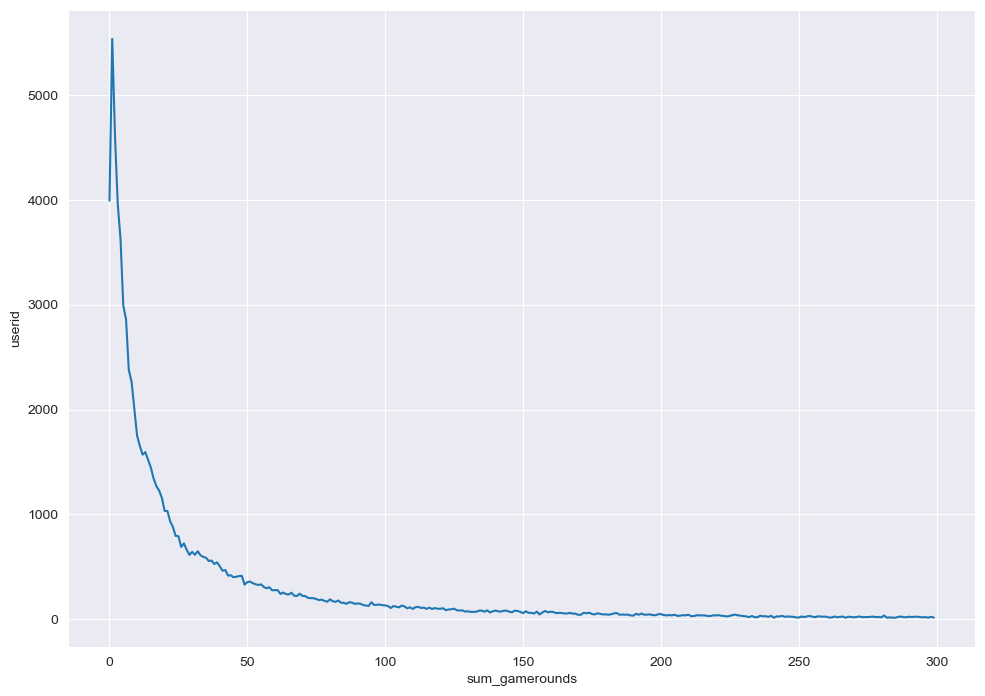

In [16]:
plt.figure(figsize = (11.7, 8.27))
sns.set_style("darkgrid") 
sns.lineplot(data = data_plot.head(300));

Разобьем данные по количеству сыгранных раундов на категории. Рассмотрим категории по количеству сыгранных игр в тестовой и контрольной группах

In [17]:
bins = pd.IntervalIndex.from_tuples([(0, 2),(2, 10), (10, 20), (20, 50),(50, 100),(100, 500),(500, 1000),(1000,50000)],closed='left')

graph_control = control_1
graph_control['range'] = pd.cut(graph_control['sum_gamerounds'],bins=bins)


In [18]:
graph_control = graph_control.groupby("range")["sum_gamerounds"].count()


In [19]:
graph_control = pd.DataFrame(graph_control).reset_index()

In [20]:
graph_test = test_1
graph_test['range'] = pd.cut(graph_test['sum_gamerounds'],bins=bins)

In [21]:
graph_test = graph_test.groupby("range")["sum_gamerounds"].count()

In [22]:
graph_test = pd.DataFrame(graph_test).reset_index()

In [23]:
merged_graph = pd.merge(graph_test,graph_control, on='range')

In [24]:
merged_graph.reset_index(inplace = True)

In [25]:
merged_graph

,index,range,sum_gamerounds_x,sum_gamerounds_y
0,0,"[0, 2)",4846,4686
1,1,"[2, 10)",12556,12149
2,2,"[10, 20)",7403,7129
3,3,"[20, 50)",8848,9407
4,4,"[50, 100)",5488,5161
5,5,"[100, 500)",5916,5740
6,6,"[500, 1000)",367,375
7,7,"[1000, 50000)",65,53


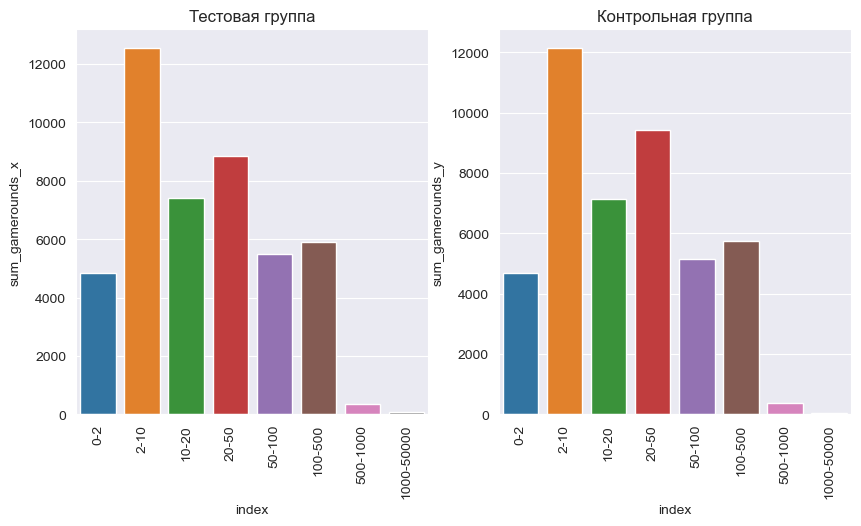

In [26]:

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
sns.set_style("darkgrid") 
fig_test = sns.barplot(data=merged_graph,x= 'index',y = 'sum_gamerounds_x',ax = axes[0])
fig_control = sns.barplot(data=merged_graph,x='index',y = 'sum_gamerounds_y', ax = axes[1])
fig_test.set_xticklabels(['0-2','2-10', '10-20', '20-50','50-100','100-500','500-1000','1000-50000'],rotation = 90)
fig_control.set_xticklabels(['0-2','2-10', '10-20', '20-50','50-100','100-500','500-1000','1000-50000'],rotation = 90)
axes[0].set_title("Тестовая группа")
axes[1].set_title("Контрольная группа");


Из диаграмм видно, что отличий в группах практически нет. Для более точной оценки совместим два графика на одном.

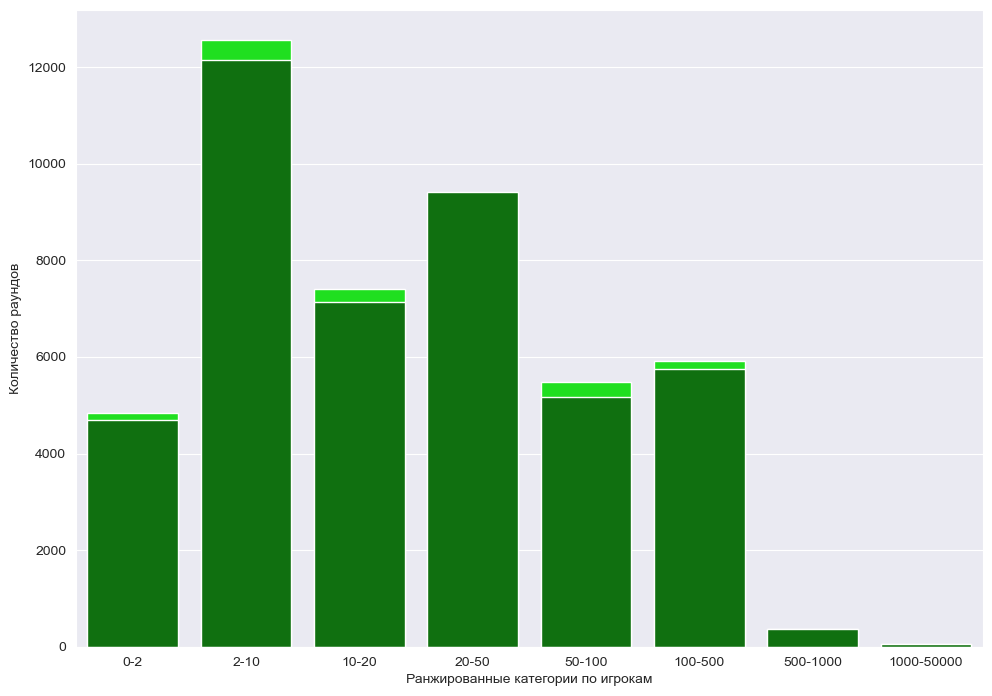

In [27]:
plt.figure(figsize = (11.7, 8.27))
sns.set_style("darkgrid") 
ax1 = sns.barplot(data=merged_graph,x= 'index',y = 'sum_gamerounds_x',color = 'lime' )
ax2 = sns.barplot(data=merged_graph,x= 'index',y = 'sum_gamerounds_y',  color = 'green')
ax1.set(ylabel='Количество раундов', xlabel='Ранжированные категории по игрокам')
ax1.set_xticklabels(['0-2','2-10', '10-20', '20-50','50-100','100-500','500-1000','1000-50000']);


#### Проверка нормальности распределения

In [28]:
stats.shapiro(control_1['sum_gamerounds'])

ShapiroResult(statistic=0.08805108070373535, pvalue=0.0)

In [29]:
stats.kstest(control_1['sum_gamerounds'],'norm')

KstestResult(statistic=0.8724176532867202, pvalue=0.0)

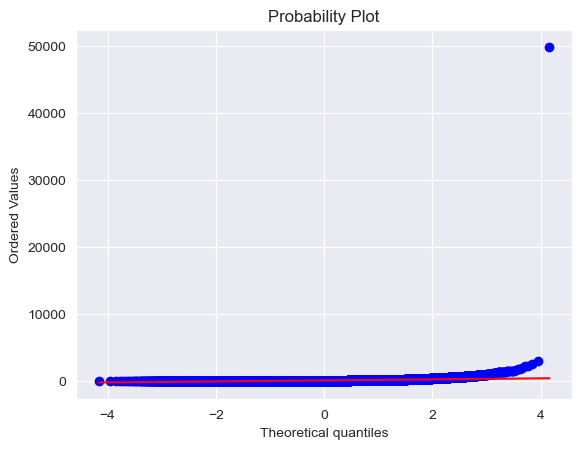

In [30]:
stats.probplot(control_1['sum_gamerounds'], dist="norm", plot=plt)
plt.show()

In [31]:
stats.shapiro(test_1['sum_gamerounds'])

ShapiroResult(statistic=0.48256635665893555, pvalue=0.0)

In [32]:
stats.kstest(test_1['sum_gamerounds'],'norm')

KstestResult(statistic=0.8707186187388001, pvalue=0.0)

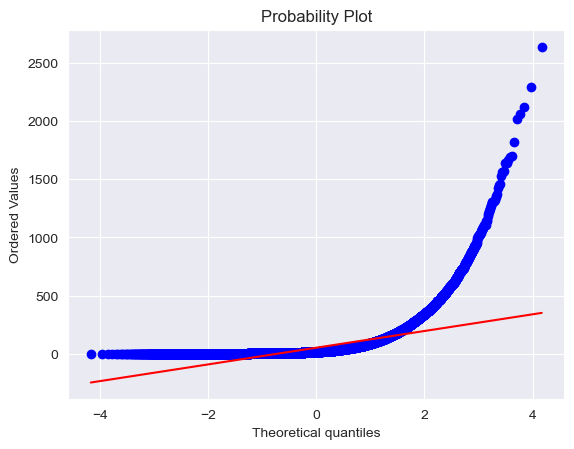

In [33]:
stats.probplot(test_1['sum_gamerounds'], dist="norm", plot=plt)
plt.show()

Результаты анализа показывают, что данные в тестовой и контрольной выборке не имеют нормального распределения. По критерию Шапиро-Уилка и критерию Колмогорова-Смирнов, значение P-value < alpha (5%.).


#### Сравнение выборок

In [34]:
stats.ttest_ind(test_1['sum_gamerounds'],control_1['sum_gamerounds'], equal_var = False)

Ttest_indResult(statistic=-0.8854374331270672, pvalue=0.37592438409326223)

Значение P-value выше уровня статистической значимости, следовательно принимем H0 о том, что статистических различий между выборками нет.

#### Расчет конверсий

1-day retention - показывает, вернулся ли пользователь на следующий день после установки приложения.
7-day retention - вернулся ли пользователь спустя неделю после установки.
Для расчета метрик воспользуемся формулой:
Вычисляется по формуле:

1day_retetntion = X_1_day / Z, где X_1_day — количество пользователей, вернувшихся в игру на следующий день, Z — общее количество людей установивших игру.
Метрика 7-day retention вычисляется таким же отношением.

In [35]:
day_one_retetntion_c = control_1["retention_1"].mean()*100
day_seven_retetntion_c = control_1["retention_7"].mean()*100
print(f'Метрика 1-day retention для контрольной группы {day_one_retetntion_c}\n\
Метрика 7-day retention для контрольной группы {day_seven_retetntion_c}\
')
      

Метрика 1-day retention для контрольной группы 44.81879194630872
Метрика 7-day retention для контрольной группы 19.020134228187917


In [36]:
day_one_retetntion_t = test_1["retention_1"].mean()*100
day_seven_retetntion_t = test_1["retention_7"].mean()*100
print(f'Метрика 1-day retention для тестовой группы {day_one_retetntion_t}\n\
Метрика 7-day retention для тестовой группы {day_seven_retetntion_t}\
')
      

Метрика 1-day retention для тестовой группы 44.22827496757458
Метрика 7-day retention для тестовой группы 18.200004396667328


In [37]:
metric_data = {'Version':['Control','Test'],'1-day retention':[day_one_retetntion_c,day_one_retetntion_t],\
               '7-day retention':[day_seven_retetntion_c,day_seven_retetntion_t]\
              }
metric_data  = pd.DataFrame(metric_data)
metric_data


,Version,1-day retention,7-day retention
0,Control,44.818792,19.020134
1,Test,44.228275,18.200004


Из полученных результатов видно, что метрики контрольной и тестовой групп практически совпадают. При этом значение метрик в тестовой группе ниже. Так разница между контрольной и тестовой группой в метрике 1-day retention составляет 0.6%, а разница метрик 7-day retention составляет 0.8%. 

#### Сравнение метрик через bootstrap

In [38]:
def proportion_result(control: pd.DataFrame,
                      treatment: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Вероятность событий
    size = control.loc[:, column].shape[0]
    prop_control = control.loc[:, column].sum() / size
    prop_treatment = treatment.loc[:, column].sum() / size
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = stats.bernoulli.rvs(p=prop_control, size=size)
        treatment_sample = stats.bernoulli.rvs(p=prop_treatment, size=size)
        booted_diff.append(np.mean(control_sample - treatment_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size = proportion.proportion_effectsize(prop_control, prop_treatment)
    
    power = zt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [39]:
proportion_result(control_1,test_1, column='retention_1')

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 236.46it/s]


,effect_size,alpha,beta,CI,difference
retention_1,-0.003823,0.564685,0.911819,"[-0.008, 0.005]",-0.001925


In [40]:
proportion_result(control_1,test_1, column='retention_7')

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 273.52it/s]


,effect_size,alpha,beta,CI,difference
retention_7,0.012776,0.055243,0.519844,"[-0.0, 0.01]",0.005001


### Выводы

* После анализа исходного набора данных можем сделать вывод о корректной работе системы сплитования  
Выборки идентичны по размеру, пользователи разделены по группам (нет значений оказавшихся одновременно в обоих группах), пропущенные значения в датасете также отсутсвуют.
* Анализ распределения показал, что данные не подчинены нормальному распределению
* Сравнение выборок показало, что статистически значимых отличий между ними нет.
* Анализ методом bootstrap дал следующие значения:  
Для метрики retention_1:
alpha = 56%, beta = 91%, доверительный интервал включает в себя нулевое значение.
Для метрики retention_7:
alpha = 56%, beta = 52%, доверительный интервал также включает в себя нулевое значение.  
Таким образом видим, что статистически значимых различий нет. Принимая во внимание наблюдаемое небольшое снижение конверсии в тестовой версии  рекомендовано оставить контрольную версию (gate_30)